In [2]:
from kfold_and_metrics import *

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
tf.keras.backend.clear_session()

import pandas as pd
import scipy.stats as ss

In [57]:
df = pd.read_csv("final.csv")
df = df.drop(columns=["id"])
print(df.shape)
df.head()

(2948, 1132)


,patient_id,diagnostics_Image-original_Mean,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_VoxelNum,diagnostics_Mask-interpolated_VolumeNum,diagnostics_Mask-interpolated_Maximum,...,diagnostics_Mask-interpolated_BoundingBox_2,diagnostics_Mask-interpolated_BoundingBox_3,diagnostics_Mask-interpolated_BoundingBox_4,diagnostics_Mask-interpolated_BoundingBox_5,diagnostics_Mask-interpolated_CenterOfMassIndex_0,diagnostics_Mask-interpolated_CenterOfMassIndex_1,diagnostics_Mask-interpolated_CenterOfMassIndex_2,diagnostics_Mask-interpolated_CenterOfMass_0,diagnostics_Mask-interpolated_CenterOfMass_1,diagnostics_Mask-interpolated_CenterOfMass_2
0,LIDC-IDRI-0001,-826.943929,5905,1,-417.494203,-990.291016,1038.270874,909,2,237.087921,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
1,LIDC-IDRI-0001,-826.943929,4613,1,-405.581777,-982.456726,949.768005,699,1,221.953705,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
2,LIDC-IDRI-0001,-826.943929,4955,1,-410.236759,-990.291016,1038.270874,772,1,237.087921,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
3,LIDC-IDRI-0001,-826.943929,5498,1,-416.576321,-990.291016,1038.270874,841,2,237.087921,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362
4,LIDC-IDRI-0002,-826.943929,10351,1,-546.359139,-1007.657349,1020.174988,749,1,160.687653,...,0.0,13.0,11.0,10.0,17.041265,16.108666,4.184319,128.652843,34.787644,-229.881362


,metric,mean,std
0,f1_score,0.345804,0.075910
1,accuracy_score,0.669345,0.058343
2,roc_auc_score,0.573651,0.039642


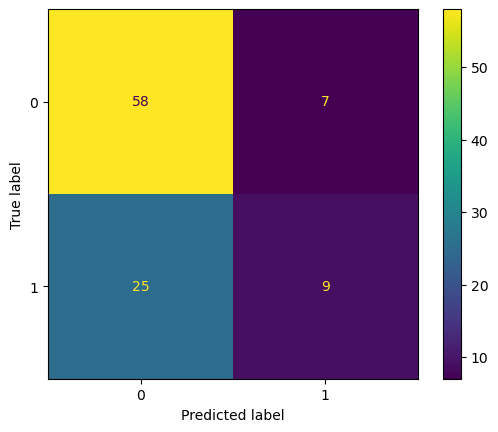

In [4]:
rf_params = {'n_estimators': 100, 'max_depth': 25, 'min_samples_leaf': 25, 'criterion': "gini"}

rf = RandomForestClassifier(**rf_params)
rf_scores = k_fold_cv(model=rf, df=df, pca_components=10, show_confusion_matrix=True)
rf_metrics = mean_std_results_k_fold_CV(rf_scores)
rf_metrics

,metric,mean,std
0,f1_score,0.435033,0.059397
1,accuracy_score,0.647402,0.035656
2,roc_auc_score,0.590902,0.031034


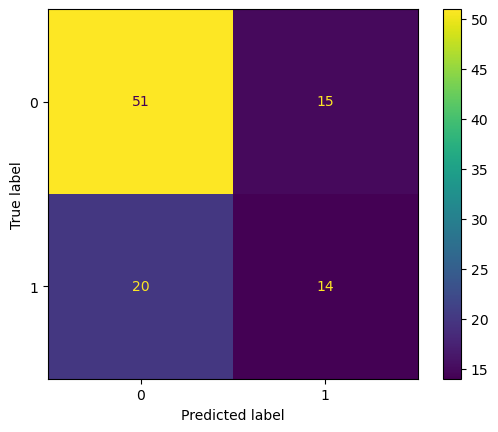

In [58]:
xgb_params = {
    'n_estimators': 150,
	'max_depth': 45,
	'min_child_weight': 5
}

xgb = XGBClassifier(**xgb_params)
xgb_scores = k_fold_cv(xgb, df, pca_components=100, show_confusion_matrix=True)
xgb_metrics = mean_std_results_k_fold_CV(xgb_scores)
xgb_metrics

,metric,mean,std
0,f1_score,0.578476,0.100646
1,accuracy_score,0.741320,0.058053
2,roc_auc_score,0.684564,0.057157


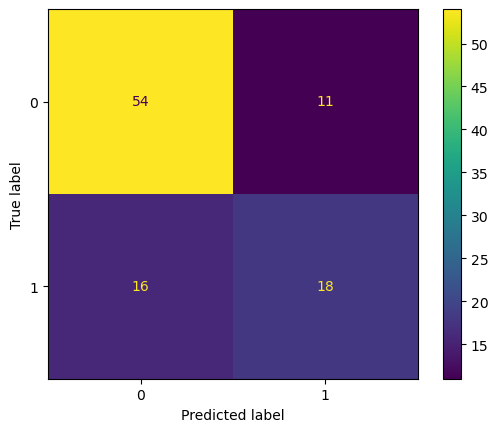

In [15]:
nn_params = {
    'hidden_layer_nodes': 60,
	'hidden_layer_activation': "relu",
	'learning_rate': 0.01
}

nn = tf.keras.models.Sequential([
    tf.keras.layers.Input((100,), name="input"),
    tf.keras.layers.Dense(nn_params['hidden_layer_nodes'], activation=nn_params['hidden_layer_activation']),
    tf.keras.layers.Dense(2,activation='softmax')
])

nn.compile(
    optimizer=tf.keras.optimizers.SGD(nn_params['learning_rate']), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

nn_scores = k_fold_cv_keras(compiled_model=nn, df=df, pca_components=100, show_confusion_matrix=True)
nn_metrics = mean_std_results_k_fold_CV(nn_score)
nn_metrics

In [55]:
# definition of the function that returns a dictionary with dataframes / tables with the pvalues between two models for each metric tested
# the pvalues were obtained from a Wilcoxon test for the median values of the metrics for all the folds performed by the models
# we chose to do a Wilcoxon's Hypothesis test since we have a small sample (10 folds) to try to understand if the models are statistically different or not for a given metric
# maybe considering confidence of 95% ?

def models_performance_comparison(scores_dict):
    # create a dataframe for each metric such that each column holds the values for a models and each row represents said models value for that metric in a specific fold
    metrics_dfs_of_fold_per_model = {}
    for model_name, model_metrics_folds_results in scores_dict.items():
        for metric_name, metric_folds_results in model_metrics_folds_results.items():
            if metric_name not in metrics_dfs_of_fold_per_model.keys():
                metrics_dfs_of_fold_per_model[metric_name] = pd.DataFrame(
                    index=[f"fold{i}" for i in range(1,len(metric_folds_results)+1)],
                    data=metric_folds_results,
                    columns=[model_name]
                )
            else: metrics_dfs_of_fold_per_model[metric_name][model_name] = metric_folds_results
    
    # for each of the dataframes created above, perform Wilcoxon's Hypothesis Test to test if there is difference in the median values of the folds for each model on said metric
    # we will perform the test for each combination of 2 models, and present the results in the form of (model 1, model 2, pvalue) in a dataframe
    metrics_dfs_of_pvalues = {}
    for metric_name, folds_models_values in metrics_dfs_of_fold_per_model.items():
        pvalues_df_data = []
        for i in range(len(folds_models_values.columns)):
            for j in range(i+1, len(folds_models_values.columns)):
                model1 = folds_models_values.columns[i]
                model2 = folds_models_values.columns[j]
                pvalue = ss.wilcoxon(folds_models_values[model1].to_numpy(), folds_models_values[model2].to_numpy()).pvalue
                pvalues_df_data.append({"model1": model1, "model2": model2, "pvalue": pvalue})
        metrics_dfs_of_pvalues[metric_name] = pd.DataFrame(data=pvalues_df_data, columns=["model1", "model2", "pvalue"])

    return metrics_dfs_of_pvalues

In [56]:
scores_dict = {
    'RF': rf_scores,
    'XGB': xgb_scores,
    'NN': nn_scores
}
metrics_dfs_of_fold_per_model = models_performance_comparison(scores_dict)

In [52]:
metrics_dfs_of_fold_per_model['accuracy_score']
# Write conclusions from the results in the table

,model1,model2,pvalue
0,RF,XGB,0.048828
1,RF,NN,0.027344
2,XGB,NN,0.003906


In [53]:
metrics_dfs_of_fold_per_model['f1_score']
# Write conclusions from the results in the table

,model1,model2,pvalue
0,RF,XGB,0.275391
1,RF,NN,0.027344
2,XGB,NN,0.037109


In [54]:
metrics_dfs_of_fold_per_model['roc_auc_score']
# Write conclusions from the results in the table

,model1,model2,pvalue
0,RF,XGB,0.921875
1,RF,NN,0.027344
2,XGB,NN,0.009766
